# Orienteering Problem

The Orienteering Problem (OP) is a routing problem where the objective is to determine the most efficient path through a set of checkpoints, maximizing the total score collected while respecting a given time limit.
The Orienteering Problem is a combination of the Traveling Salesman Problem (TSP) and the Knapsack Problem. It involves finding a path that visits a subset of given locations, each with an associated score, such that the total score is maximized and the total travel time does not exceed a specified limit.

## Motivation
The OP has practical applications in various fields such as logistics, tourism, and robotics. For example, in a tourist route planning scenario, the goal is to maximize the number of attractions visited within a limited time. In logistics, it can be used to optimize delivery routes to maximize customer satisfaction while minimizing travel time.

## Model
The Orienteering Problem can be modeled as a graph where nodes represent locations and edges represent travel times between locations. Each node has a score, and the objective is to find a path that maximizes the total score while ensuring the total travel time is within the given limit. The problem can be formulated as an integer linear programming (ILP) model or solved using heuristic and metaheuristic approaches.

### Integer Linear Programming (ILP) Model

Let:
- $ V $ be the set of locations (nodes).
- $ E $ be the set of edges representing travel times between locations.
- $ s_i $ be the score of location $ i $.
- $ t_{ij} $ be the travel time between location $ i $ and location $ j $.
- $ T $ be the maximum allowed travel time.
- $ x_{ij} $ be a binary variable that is 1 if the path includes the edge from $ i $ to $ j $, and 0 otherwise.
- $ y_i $ be a binary variable that is 1 if location $ i $ is visited, and 0 otherwise.

Objective:
$$ \max \sum_{i \in V} s_i y_i $$

Subject to:
1. Each location is visited at most once:
$$ \sum_{j \in V} x_{ij} \leq 1 \quad \forall i \in V $$
$$ \sum_{i \in V} x_{ij} \leq 1 \quad \forall j \in V $$

2. The total travel time does not exceed the limit:
$$ \sum_{(i,j) \in E} t_{ij} x_{ij} \leq T $$

3. Subtour elimination constraints to ensure a single path:
$$ \sum_{(i,j) \in E} x_{ij} \geq y_i \quad \forall i \in V $$
$$ \sum_{(i,j) \in E} x_{ij} \leq |V| - 1 $$

4. Binary constraints:
$$ x_{ij} \in \{0, 1\} \quad \forall (i,j) \in E $$
$$ y_i \in \{0, 1\} \quad \forall i \in V $$


### Note on MTZ Subtour Elimination Constraints

In the sequel, we will use the Miller-Tucker-Zemlin (MTZ) subtour elimination constraints to ensure that the solution forms a single path without subtours. The MTZ constraints introduce additional variables and constraints to the ILP model to prevent the formation of subtours, which are smaller loops within the path that do not contribute to the overall objective. These constraints are commonly used in routing problems to maintain the integrity of the solution.

To eliminate subtours, we introduce additional variables $u_i$ for each location $i \in V$. These variables help to maintain the order of visits and ensure that no subtours are formed.

Let $u_i$ be a continuous variable representing the position of location $i$ in the path.

The MTZ constraints are formulated as follows:

1. The position of the starting location is fixed:
$$ u_1 = 1 $$

2. The position of each visited location must be greater than the position of the previous location plus one:
$$ u_i - u_j + |V| x_{ij} \leq |V| - 1 \quad \forall (i,j) \in E, \, i \neq j, \, j\neq 1 $$

3. The position variables are bounded:
$$ 2 \leq u_i \leq |V| \quad \forall i \in V, \, i \neq 1 $$

These constraints ensure that the solution forms a single path without subtours by maintaining a consistent order of visits.

## An Illustrative Example

To illustrate the Orienteering Problem, let's consider a simple example with five locations. Each location has an associated score, and the travel times between locations are given by the following distance matrix:

|   | A | B | C | D | E |
|---|---|---|---|---|---|
| A | 0 | 2 | 9 | 10| 7 |
| B | 2 | 0 | 6 | 4 | 3 |
| C | 9 | 6 | 0 | 8 | 5 |
| D | 10| 4 | 8 | 0 | 6 |
| E | 7 | 3 | 5 | 6 | 0 |

The scores for the locations are as follows:
- A: 10
- B: 8
- C: 7
- D: 6
- E: 5

The objective is to find a path that maximizes the total score while ensuring the total travel time does not exceed a specified limit.

## Setting the Environnement

Note: you may need to restart the kernel to use updated packages.


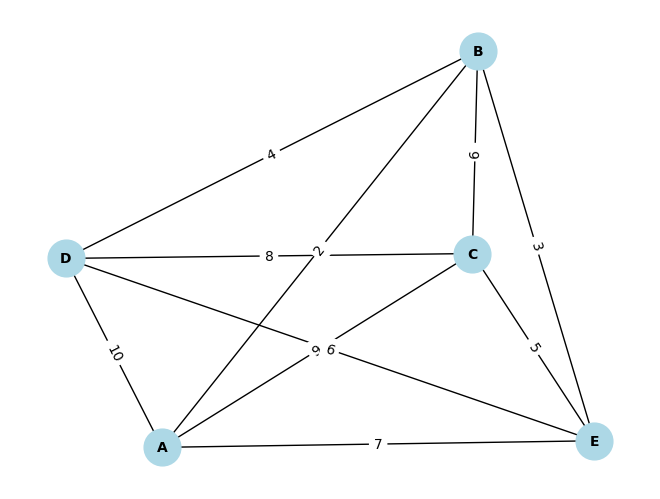

In [37]:
%pip install matplotlib pandas numpy pulp networkx

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pulp as pl
import networkx as nx

# The distance matrix
distances = pd.DataFrame({
    'A': [0, 2, 9, 10, 7],
    'B': [2, 0, 6, 4, 3],
    'C': [9, 6, 0, 8, 5],
    'D': [10, 4, 8, 0, 6],
    'E': [7, 3, 5, 6, 0]
}, index=['A', 'B', 'C', 'D', 'E'])

scoring = {
    'A': 10,
    'B': 8,
    'C': 7,
    'D': 6,
    'E': 5
}

# Create a graph from the distance matrix
G = nx.from_pandas_adjacency(distances)

# Add scores as node attributes
for node in G.nodes:
    G.nodes[node]['score'] = scoring[node]

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

## Creating the Model in PULP

In [47]:
# Define the problem
prob = pl.LpProblem("OrienteeringProblem", pl.LpMaximize)

# Define decision variables
x = pl.LpVariable.dicts("x", [(i, j) for i in distances.index for j in distances.columns], cat='Binary')
y = pl.LpVariable.dicts("y", distances.index, cat='Binary')
u = pl.LpVariable.dicts("u", distances.index, lowBound=1, upBound=len(distances), cat='Continuous')

# Objective function: Maximize the total score
prob += pl.lpSum(scoring[i] * y[i] for i in distances.index), "TotalScore"

# Constraints
# Each location is visited at most once
for i in distances.index:
    prob += pl.lpSum(x[i, j] for j in distances.columns if j != i) == y[i], f"VisitOnceOut_{i}"
    prob += pl.lpSum(x[j, i] for j in distances.columns if j != i) == y[i], f"VisitOnceIn_{i}"

# The total travel time does not exceed the limit
prob += pl.lpSum(distances.loc[i, j] * x[i, j] for i in distances.index for j in distances.columns) <= T, "TimeLimit"

# Subtour elimination constraints
for i in distances.index:
    for j in distances.columns:
        if i != j and j!= 'A':
            prob += u[i] - u[j] + len(distances) * x[i, j] <= len(distances) - 1, f"SubtourElimination_{i}_{j}"

for i in distances.index:
    if i != 'A':
        u[i].lowBound = 2
    else:
        prob += u[i] == 1, f"StartPosition_{i}"
    
print(prob)



OrienteeringProblem:
MAXIMIZE
10*y_A + 8*y_B + 7*y_C + 6*y_D + 5*y_E + 0
SUBJECT TO
VisitOnceOut_A: x_('A',_'B') + x_('A',_'C') + x_('A',_'D') + x_('A',_'E')
 - y_A = 0

VisitOnceIn_A: x_('B',_'A') + x_('C',_'A') + x_('D',_'A') + x_('E',_'A') - y_A
 = 0

VisitOnceOut_B: x_('B',_'A') + x_('B',_'C') + x_('B',_'D') + x_('B',_'E')
 - y_B = 0

VisitOnceIn_B: x_('A',_'B') + x_('C',_'B') + x_('D',_'B') + x_('E',_'B') - y_B
 = 0

VisitOnceOut_C: x_('C',_'A') + x_('C',_'B') + x_('C',_'D') + x_('C',_'E')
 - y_C = 0

VisitOnceIn_C: x_('A',_'C') + x_('B',_'C') + x_('D',_'C') + x_('E',_'C') - y_C
 = 0

VisitOnceOut_D: x_('D',_'A') + x_('D',_'B') + x_('D',_'C') + x_('D',_'E')
 - y_D = 0

VisitOnceIn_D: x_('A',_'D') + x_('B',_'D') + x_('C',_'D') + x_('E',_'D') - y_D
 = 0

VisitOnceOut_E: x_('E',_'A') + x_('E',_'B') + x_('E',_'C') + x_('E',_'D')
 - y_E = 0

VisitOnceIn_E: x_('A',_'E') + x_('B',_'E') + x_('C',_'E') + x_('D',_'E') - y_E
 = 0

TimeLimit: 2 x_('A',_'B') + 9 x_('A',_'C') + 10 x_('A',_'D') 

## Solving the OP

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/vincent/GitHub/Course-Materials/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/827ee3742c7b40f69162b49097c8e619-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/827ee3742c7b40f69162b49097c8e619-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 33 COLUMNS
At line 208 RHS
At line 237 BOUNDS
At line 273 ENDATA
Problem MODEL has 28 rows, 30 columns and 119 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 34 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 12 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 12 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 12 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 12 strengthened rows, 0 substitutions
Cgl0004I processed m

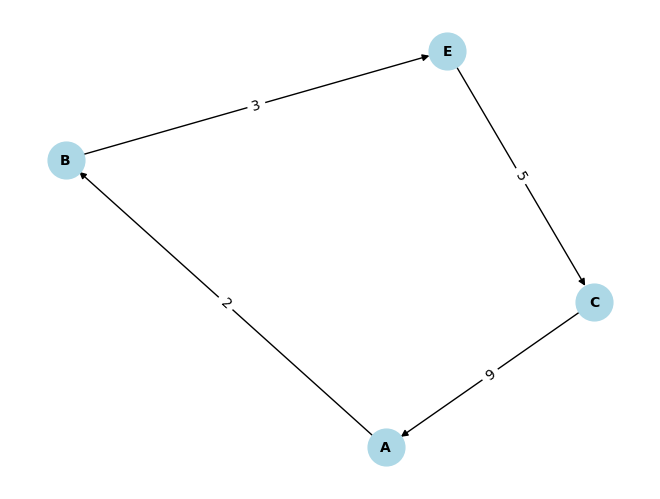

In [48]:
# Solve the problem
prob.solve()

# Print the results
print("Status:", pl.LpStatus[prob.status])
print("Total Score:", pl.value(prob.objective))
for v in prob.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)
        
# Create the solution graph
G_solution = nx.DiGraph()
for i in distances.index:
    for j in distances.columns:
        if i!=j and x[i, j].varValue > 0:
            G_solution.add_edge(i, j, weight=distances.loc[i, j])
            
# Draw the solution graph
pos = nx.spring_layout(G_solution)
nx.draw(G_solution, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G_solution, 'weight')

nx.draw_networkx_edge_labels(G_solution, pos, edge_labels=labels)

plt.show()
